# Multiple Regression and Model Building

## Introduction

In the last chapter we were running a simple linear regression on cereal data. We wanted to see if there was a relationship between the cereal's nutritional rating and its sugar content. There was. But with all this other data, like fiber(!), we want to see what other variables are related, in conjunction with (and without) each other. Multiple regression seems like a friendly tool we can use to do this, so that's what we'll be doing here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm




sns.set()
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.precision', 2)
%matplotlib notebook
plt.rcParams['figure.figsize'] = 10, 10

## Getting the Data

In [2]:
#Load dataset into dataframe
df = pd.read_csv("cereals.csv")
display(df.head())

,Name,Manuf,Type,Calories,Protein,Fat,Sodium,Fiber,Carbo,Sugars,...,Weight,Cups,Rating,Cold,Nabisco,Quaker,Kelloggs,GeneralMills,Ralston,AHFP
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6.0,...,1.0,0.33,68.40,1,1,0,0,0,0,0
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8.0,...,1.0,1.00,33.98,1,0,1,0,0,0,0
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5.0,...,1.0,0.33,59.43,1,0,0,1,0,0,0
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0.0,...,1.0,0.50,93.70,1,0,0,1,0,0,0
4,Almond_Delight,R,C,110,2,2,200,1.0,14.0,8.0,...,1.0,0.75,34.38,1,0,0,0,0,1,0


If you weren't around for the chapter on simple linear regressions, we noted that the *sugars* value was missing at index 57, so we wiped that record from the dataframe. I do so here, and again just before I create the model for the multiple linear regression.

In [3]:
sugars = df['Sugars'].values
rating = df['Rating'].values
fiber = df['Fiber'].values
shelves = df['Shelf'].values

sugars = np.delete(sugars, 57)
rating = np.delete(rating, 57)
fiber = np.delete(fiber, 57)
shelves = np.delete(shelves, 57)
print(shelves)

[3 3 3 3 3 1 2 3 1 3 2 1 2 3 2 1 1 2 2 3 2 3 3 3 2 1 2 3 3 2 1 2 3 3 3 2 1
 1 3 3 2 2 2 2 3 3 3 1 2 3 3 3 3 3 3 3 3 2 3 3 1 1 1 1 1 2 1 2 3 3 3 3 2 1
 1 1]


Typically I don't use the interactive notebook because 2D graphics usually suffice, and 3D sometimes behaves in a funny way, but this scatterplot functionality is really cool. Working with a 3D scatterplot, you absolutely need interactivity. Here, the shade of the color indicates closeness. Darker colors are closer, and lighter colors are further. So you can gain some familiarity with the variables and their overall range of values by looking one variable at a time. For example, if you rotate to where Sugar is the focus, you know color will be associated with Fiber; so many of the points are the same shade, so you know there isn't much diversity in fiber, or that they're all close to each other in value. When you rotate to Fiber being in the forefront, you notice that there are in fact a lot of different shades of red, thus Sugar holds a wider range of values, since they aren't all close in proximity. And with Ratings being held in constant on the Y-axis, its range of values is clear spatially, not requiring the use of color.

<IPython.core.display.Javascript object>


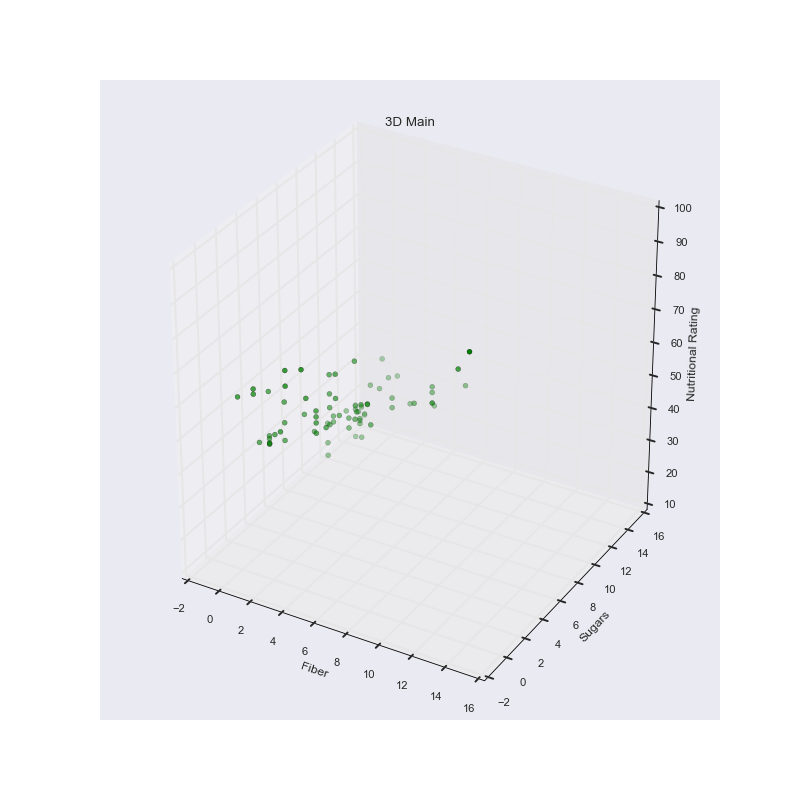

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fiber, sugars, rating, c = "g")
ax.set_xlabel('Fiber')
ax.set_ylabel('Sugars')
ax.set_zlabel('Nutritional Rating')
plt.title("3D Main")

<IPython.core.display.Javascript object>


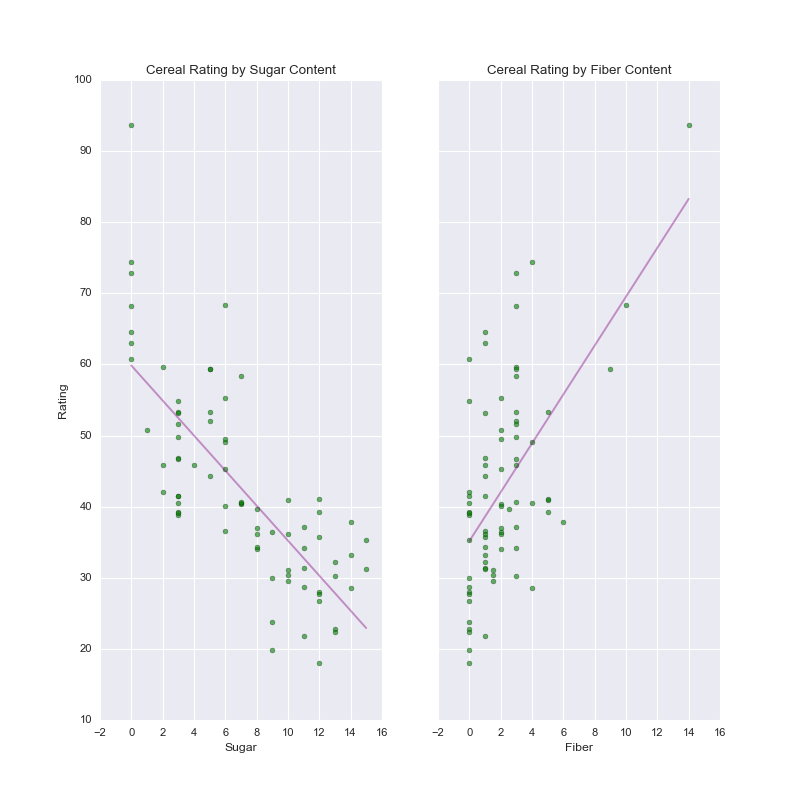

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(sugars, rating, c = 'g', alpha = 0.6)
ax1.set_xlabel('Sugar')
ax1.set_ylabel('Rating')
ax1.set_title('Cereal Rating by Sugar Content')

ax2.scatter(fiber, rating, c = 'g', alpha = 0.6)
ax2.set_xlabel('Fiber')
ax2.set_title('Cereal Rating by Fiber Content')

sugars2 = sm.add_constant(sugars)
lm1 = sm.OLS(rating, sugars2).fit()
fiber2 = sm.add_constant(fiber)
lm2 = sm.OLS(rating, fiber2).fit()

sugar_line = np.linspace(sugars.min(), sugars.max())
sugar_line = sm.add_constant(sugar_line)
y_hat1 = lm1.predict(sugar_line)

fiber_line = np.linspace(fiber.min(), fiber.max())
fiber_line = sm.add_constant(fiber_line)
y_hat2 = lm2.predict(fiber_line)

ax1.plot(sugar_line[:, 1], y_hat1, 'purple', alpha=0.4)
ax2.plot(fiber_line[:, 1], y_hat2, 'purple', alpha=0.4)

A random note, in these subplots we can see a straight line indicating the linear regression. You can assume these lines exist within the 3D scatterplot that lies above these two subplots, but instead of two lines representing the regression, it's actually a hyperplane. This flat plane (not visualized above) encompasses depth and direction, rather than just the direction of these lines.

In [6]:
df = df.drop(df.index[57])
X = df[['Sugars', 'Fiber']]
y = df['Rating']

X = sm.add_constant(X)
mreg = sm.OLS(y, X).fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     162.3
Date:                Tue, 25 Jul 2017   Prob (F-statistic):           1.35e-27
Time:                        14:44:55   Log-Likelihood:                -244.08
No. Observations:                  76   AIC:                             494.2
Df Residuals:                      73   BIC:                             501.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         52.1742      1.556     33.541      0.000        49.074    55.274
Sugars        -2.2436      0.163    -13.750      0.000        -2.569    -1.918
Fiber          2.8665      0.298      9.623      0.000         2.273     3.460
==============================================================================
Omnibus:                        5.731   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.767
Skew:                           0.669   Prob(JB):                       0.0559
Kurtosis:                       2.822   Cond. No.                         18.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Multiple Regression Results and Inference

**$R^2$:** Usually $R^2$ helps us find best fit. Multiple regressions are a little nuaunced—when you add variables to a model, you'll inevitabely increase the $R^2$ value, even if the variables are useless. ${R^2}_{adj.}$ values account for this, where they penalize $R^2$ values that include predictors — i.e. independent variables — that aren't useful to the model. If the $R^2_{adj.}$ is much less than the $R^2$, it's a sign that at least one variable in the model may be extraneous, and an analyst should find and omit it. In our case, there isn't a significant difference, so we can leave it for now.

**F-statistic:** The F-test is for assessing the significance of the overall regression model; in a multiple regression, it compares a model with no predictors (in this case, no sugar and no fiber), referred to as the intercept-only model, to the specified model (inclusive of those two predictors listed above). The null hypothesis is that these two models are equal, and the alternative hypothesis is that the intercept-only model is worse than our model. We will get back a p-value that helps us choose whether to reject or accept the null hypothesis. Given these p-values are approximately zero, we can reject the null. In plain English, there is evidence that there is a linear relationship between nutritional rating, and the set of predictors (sugar and fiber), since the F-test only accounts for the target variable and the set of all predictor variables, not considering the individual effects of each predictor. *Note, in case unaware, within the upper table the p-value of the F-statistic is listed as Prob (F-statistic).

**T-test:** The t-test behaves in a different way from the F-test in that it looks at the relationship between the target variable, and every predictor variable, independently. Considering $B_i$ is the population parameter of the $i^{th}$ variable, the null hypothesis is that for the regression, this population parameter is going to be equal to zero, and the alternative is that Bi will not be equal to zero. In essence, we're considering the absence of the ith term, so interpretations of this must include some reference to other predictors being held constant. Here, our value of sugar is -2.24, the t-statistic is -13.750, and the p-value is approximately 0. Using the p-value method, the null is rejected when the p-value of the test statistic is small. Ours is ~0, so our null hypothesis is rejected. *There is evidence for a linear relationship between nutritional rating and sugar, in the presence of fiber content.* Likewise, our $b_2$ (fiber's coefficient) is -2.8665, t-statistic is 9.62, and p-value is approximately 0, so again, our conclusion is to reject the null hypothesis. *There is evidence for a linear relationship between nutritional rating and fiber content, in the presence of sugar content.

<IPython.core.display.Javascript object>


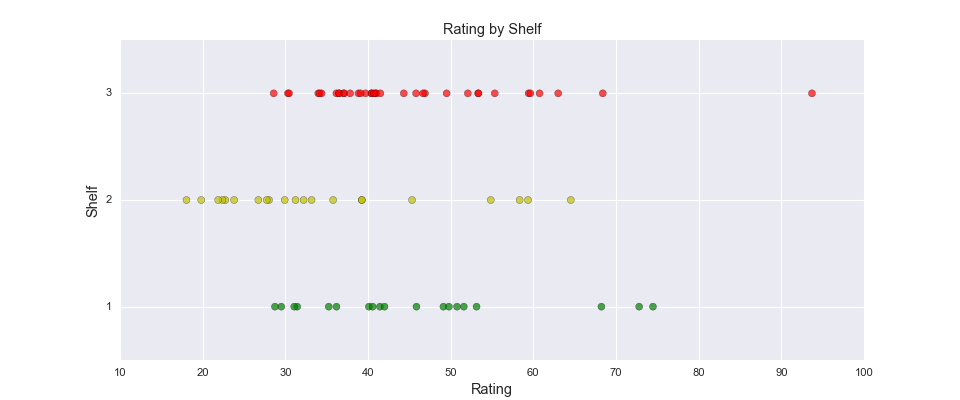

In [7]:
colours = [ 'g', 'y', 'r'] #I use colours because I don't want to overwrite any important matplotlib code; I'm American
fig, ax = plt.subplots(figsize=(12,5))
points = ax.scatter(rating, shelves, c = [colours[i] for i in shelves - 1], marker = 'o', s=40, alpha = .7)
plt.yticks([1, 2, 3])
plt.ylabel('Shelf', size = 13)
plt.xlabel('Rating', size = 13)
plt.title('Rating by Shelf', size = 13)

A random note on design decisions; it's good to be mindful of the colorblind. Certain groupings of colors are indistinguishable from each other. That said, the color of these categories isn't really a big deal since their proximity makes them distinct. In other cases, it's good to be mindful of color simply because they can distort perception, but again, this isn't a concern here.

## Using Categorical Variables in Multiple Regressions

In the above plot, we see that shelf 2 has a cluster of cereals that have low nutritional ratings. That's interesting. It could be due to sugary cereals being the most popular, so it's always at arms reach. And with other cereals at children's eye level (shelf 1), perhaps they can get some additional sales in. Regardless, we still want to include the shelves in our regression to see if there is any sort of relationship between nutritional rating and shelf level. To use this variable in a regression, we have to transform the categorical variable into a flag / dummy / indicator variable. This is a binary variable (it has a value of 0 or 1), which takes the value 1 if the observation belongs to the given category, and 0 otherwise. Below, the first five cereals are all on shelf 3. The 0.0's in the shelf_1 and shelf_2 column indicate that each observation (cereal) is neither on shelf 1, nor shelf 2.

In [8]:
dummy_shelves = pd.get_dummies(df['Shelf'], prefix = 'shelf')

In [9]:
display(dummy_shelves.head())

,shelf_1,shelf_2,shelf_3
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [10]:
type(dummy_shelves)

pandas.core.frame.DataFrame

In [11]:
print(len(df))
print(len(dummy_shelves))

76
76


So now we can see that our dummy_shelves variable points to a dataframe. Its length is the same as the original cereal dataframe that we're working with, which means we're ready to concatenate the two frames into one.

In [12]:
df = pd.concat([df, dummy_shelves], axis = 1)

In [13]:
print(list(df))

['Name', 'Manuf', 'Type', 'Calories', 'Protein', 'Fat', 'Sodium', 'Fiber', 'Carbo', 'Sugars', 'Potass', 'Vitamins', 'Shelf', 'Weight', 'Cups', 'Rating', 'Cold', 'Nabisco', 'Quaker', 'Kelloggs', 'GeneralMills', 'Ralston', 'AHFP', 'shelf_1', 'shelf_2', 'shelf_3']


The concatenation was a success. This is how the multiple linear regression model will look using the two indicator variables:

$y_{hat} = b_0 + b_1sugar + b_2fiber + b_3shelf1 + b_4shelf2$

Multiple regressions for the relationships between rating, sugar, fiber, and shelf location (notice the 0 or 1 being substituted in for the indicators):

**Cereals on Shelf 1:** $y_{hat} = b_0 + b_1sugar + b_2fiber + b_3(1) + b_4(0) = (b_0 + b_3) + b_1sugar + b_2fiber$

**Cereals on Shelf 2:** $y_{hat} = b_0 + b_1sugar + b_2fiber + b_3(0) + b_4(1) = (b_0 + b_4) + b_1sugar + b_2fiber$

**Cereals on Shelf 3:** $y_{hat} = b_0 + b_1sugar + b_2fiber + b_3(0) + b_4(0) = b_0 + b_1sugar + b_2fiber$

Earlier we noted that linear regressions use a simple line to fit the data, but multiple regressions use planes. These three models above represent three parallel planes.

In [14]:
X2 = df[['shelf_1', 'shelf_2']]
y = df['Rating']
X2 = sm.add_constant(X2)
mreg2 = sm.OLS(y, X2).fit()
print(mreg2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.614
Date:                Tue, 25 Jul 2017   Prob (F-statistic):             0.0130
Time:                        14:44:55   Log-Likelihood:                -303.97
No. Observations:                  76   AIC:                             613.9
Df Residuals:                      73   BIC:                             620.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         45.2200      2.246     20.136      0.0

In [15]:
mreg3 = smf.ols(formula='Rating ~ Sugars + Fiber + shelf_1 + shelf_2', data = df).fit()
print(mreg3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     85.21
Date:                Tue, 25 Jul 2017   Prob (F-statistic):           2.40e-26
Time:                        14:44:55   Log-Likelihood:                -241.69
No. Observations:                  76   AIC:                             493.4
Df Residuals:                      71   BIC:                             505.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     50.5245      1.851     27.293      0.0

<IPython.core.display.Javascript object>


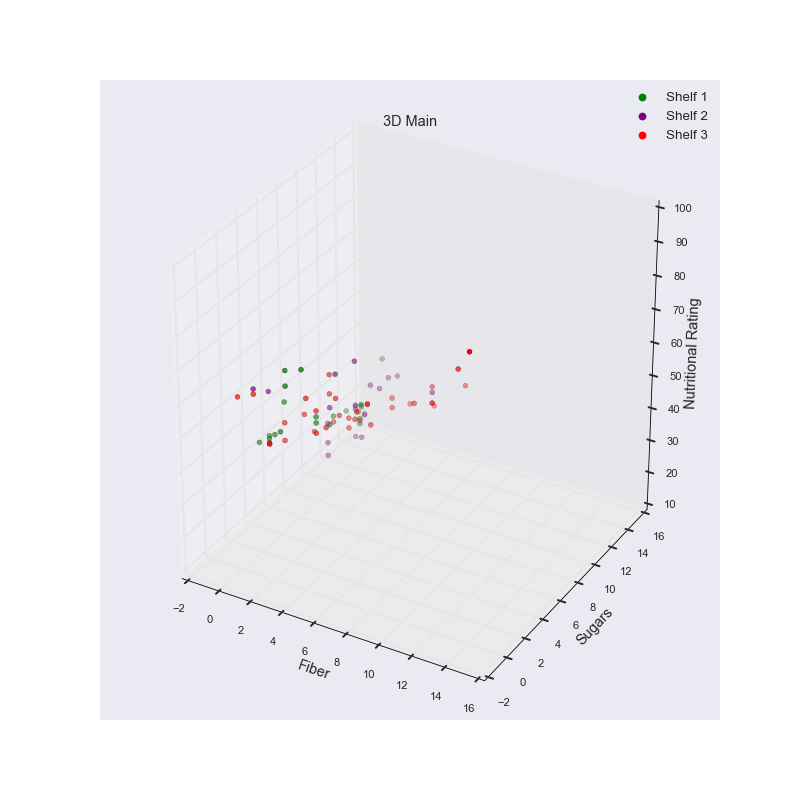

In [16]:
colours = [ 'g', 'purple', 'r']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fiber, sugars, rating, c = [colours[i] for i in shelves - 1])
ax.set_xlabel('Fiber', size = 13)
ax.set_ylabel('Sugars', size = 13)
ax.set_zlabel('Nutritional Rating', size = 13)


scatter1_proxy = plt.Line2D([0],[0], linestyle="none", c=colours[0], marker = 'o')
scatter2_proxy = plt.Line2D([0],[0], linestyle="none", c=colours[1], marker = 'o')
scatter3_proxy = plt.Line2D([0],[0], linestyle="none", c=colours[2], marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], ['Shelf 1', 'Shelf 2', 'Shelf 3'], numpoints = 1, fontsize = 12)
plt.title("3D Main", size = 13)

Shoutout to [M4rtini from StackOverflow](https://stackoverflow.com/a/20505720/4864602) for giving this answer on how to provide a legend in 3D scatterplots. I definitely would not have known that you have to create proxies, but I suppose it makes sense; given that I had one plot created, I only had one item in the legend appearing.

As with the last 3D scatterplot, the brightness of the colors represent proximity. The brighter, the closer, the dimmer, the further.

# Selecting Variables to Include or Exclude in the Regression

Regressions are finicky when it comes to which variables are used. The regression's $R^2$ tends to rise as more and more variables are added, even if they have no significant contribution. If some of the predictors are correlated, F-tests can come out significant (remember, F-tests suggest the strength of the entire model), even if none of the t-tests for the individual predictors are significant. And when there is correlation between the supposed independent variables, the coefficient estimates for $b_1$ and $b_2$ because of the inflated values for $s_{b1}$ and $s_{b2}$ (the sample standard errors, or the variability of these slopes).

In [17]:
mreg4_1 = smf.ols(formula='Rating ~ Sugars + Fiber + shelf_2', data = df).fit()
mreg4_2 = smf.ols(formula='Rating ~ shelf_1 + shelf_2 + Sugars + Fiber', data = df).fit()
print(mreg4_1.summary())
print(mreg4_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     112.6
Date:                Tue, 25 Jul 2017   Prob (F-statistic):           4.06e-27
Time:                        14:44:55   Log-Likelihood:                -242.42
No. Observations:                  76   AIC:                             492.8
Df Residuals:                      72   BIC:                             502.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     51.7089      1.554     33.269      0.0

In the first model, 'Rating ~ Sugars + Fiber + shelf_2' is 0.828 and $R^2_{adj.}$ is 0.818. Without Shelf 1, the penalty is .010. With Shelf 1 included, 'Rating ~ shelf_1 + shelf_2 + Sugars + Fiber', $R^2$ is 0.824 and $R^2_{adj.}$ is 0.818, the penalty is .007. The penalty for having Shelf 1 included is greater than the penalty of having it excluded. We noted that $R^2_{adj.}$ compensats for having extraneous variables, but the penalty of having Shelf 1 as a variable is so small, we can be a little more sure that it isn't excess.

## Sequential Sum of Squares with ANOVA

Sequential sum of squares is a useful procedure for choosing which variables to use in a model, and an analysis of variance (ANOVA) will give us the sums of squares per each predictor that we need to do it. It partitions the SSR — the proportion of the variability in the target variable that is explained by the linear relationship of the target variable with the *set* of predictor variables — into the unique portions of the SSR that are explained by the particular predictors, given any earlier predictors. For example, the sequential sum of squares for Sugars is 8711, and that represents the variability in the nutritional rating that is explained by the linear relationship between rating and sugar content. The second sequential sum of squares, for fiber content, equals 3476; this represents the unique additional variability in nutritional rating that is explained by the linear relationship of rating with fiber content, given that the variability explained by sugars has already been extracted. The third sequential sum of squares, for shelf_2, is 117. Given that fiber and sugar were extracted, this small value indicates that the variable is probably not useful for estimating rating. Because this sequentially assesses variability, given the preceeding predictor's variability, the ordering of the variables matters. In other words, you would want to list your more definitive variables first (like fiber), and the less-sure variables towards the end (like the various shelves).

In [18]:
anova_results = anova_lm(mreg4_1)
anova_results2 = anova_lm(mreg4_2)
display(anova_results)
display(anova_results2)

,df,sum_sq,mean_sq,F,PR(>F)
Sugars,1.0,8711.93,8711.93,239.09,1.40e-24
Fiber,1.0,3476.64,3476.64,95.41,7.89e-15
shelf_2,1.0,117.19,117.19,3.22,7.71e-02
Residual,72.0,2623.53,36.44,NaN,NaN


,df,sum_sq,mean_sq,F,PR(>F)
shelf_1,1.0,282.72,282.72,7.80,6.71e-03
shelf_2,1.0,1392.70,1392.70,38.42,3.34e-08
Sugars,1.0,7178.98,7178.98,198.03,3.17e-22
Fiber,1.0,3501.04,3501.04,96.58,7.08e-15
Residual,71.0,2573.86,36.25,NaN,NaN


## Multicollinearity

Per usual, we should be on guard against multicollinearity, so we have to check out the correlation structure between the predictor variables.

In [19]:
display(df[['Fiber','Sugars','shelf_2']].corr())
display(df[['Fiber', 'Sugars', 'Potass']].corr())

,Fiber,Sugars,shelf_2
Fiber,1.00,-0.14,-0.32
Sugars,-0.14,1.00,0.37
shelf_2,-0.32,0.37,1.00


,Fiber,Sugars,Potass
Fiber,1.00,-1.39e-01,9.12e-01
Sugars,-0.14,1.00e+00,1.41e-03
Potass,0.91,1.41e-03,1.00e+00


Naturally this table has some useful information. But being human, we don't do as well in processing the meaning of numbers, so we can look to visualizations to really beat out the relationships between the pairs of variables. The 0.91 correlation coefficient makes much more sense when we look at the visual relationship between Fiber and Potassium.

<IPython.core.display.Javascript object>


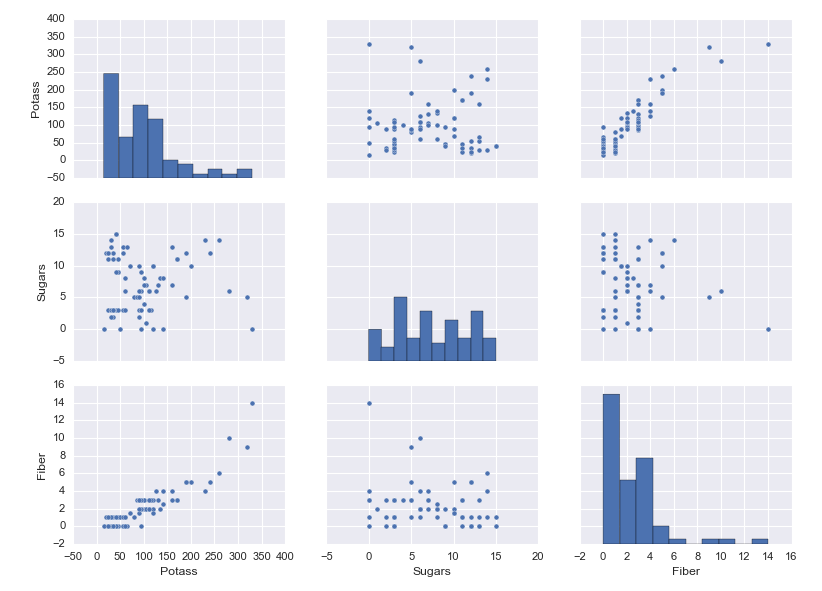

In [20]:
sns.pairplot(df.dropna(), vars = ['Potass', 'Sugars', 'Fiber'])

## Model Selection

Variable selection methods have been developed to help choose which variables to include in multiple regressions.
* Backward Elimination
* Forward Selection
* Stepwise Selection
* Best Subsets

These variable selection methods are essentially algorithms that help to construct the model that has an optimal set of predictors (no excess, but enough to get the most accurate predictive power). This is done by evaluating F-statistics.

In order to evaluate the F-statistics, there are a lot of comparisons being made. First and foremost, there is a complete model containing all of the terms, like $E[Y] = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \beta_4X_4$, and a reduced model, like $E[Y] = \beta_0 + \beta_1X_1 + \beta_2X_2$. Additional terms of the complete model will make the $R^2$ value higher, and we want to understand if the influence of these variables is *statistically significant*, or if it's just random. A partial F-test helps us with this. We calculate the extra (sequential) sum of squares from adding x* (the variable of interest) to the model, given that $x_1, x_2, ..., x_p$ are already in the model. 

$SS_{EXTRA} = SS_{FULL} - SS_{REDUCED}$
$SS(x* | x_1, x_2, x_3, ..., x_p) = SS(x_1, x_2, x_3, ... x_p, x*) - SS(x_1, x_2, x_3, ..., x_p)$

The null hypothesis for the partial F-test, $H_0:$ No, the extra SSE associated with x\* does not contribute significantly to the regression sum of squares model, so do not include it.

**Backward Elimination:** 
1. Start with the model with all predictors
2. Delete variable with smallest F-statistic
3. Refit with this variable deleted. Recompute all F-statistics for deleting one of the remaining variables, and delete the variable with the smallest F-statistic
4. Continue until every remaining variable is significant at cutoff

*Note, you may choose any value critical value $\alpha$ to determine significance; lower values make it more difficult to retain variables in the model.

**Forward Selection:** 
1. Start with a model with no predictors
2. Add variable with largest F-statistic; pick $\alpha$ (usually 0.05)
3. Refit with this variable; recompute all F-statistics for adding one of the remaining variables, and add the next variable with the largest test statistic
4. Continue until no variable is significant at cutoff

You can do this in Python with sklearn's [F-regression](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html). If this is confusing, [Winks](https://stats.stackexchange.com/a/207396/163011) does a good job in explaining how it works on StackOverflow.

See the example below all of this text.

**Stepwise Selection:**
1. Start with a model with no predictors
2. Add variable with largest F-statistic (provided $p$ is less than some cutoff)
3. Refit with this variable added. Recompute all F-statistics for adding one of hte remaining variables, and then add the variable with the largest F-statistic
4. At each step after adding a variable, try to eliminate any variable not significant at any level (do backwards elimination until that stops)
5. After doing the backwards step, take another forward step
6. Continue until every remaining variable is significant at cutoff level and every excluded variable is insignificant

**Best Subsets:**
1. Specify how many (k) models of each size you want reported, as well as the maximum number of predictors (p) that you want in the model
2. All models of one predictor are built. Their $R^2$, $R^2_{adj.}$, Mallow's $C_p$, and s values are all calculated, and the best k models are reported, based on these measures
3. Then all models of two predictors are built. Their $R^2$, $R^2_{adj.}$, Mallow's $C_p$, and s values are all calculated, and the best k models are reported, based on these measures
4. The procedure continues in this way until the maximum number of predictors (p) is reached. Then you will have a list of the best models of each size, $1, 2, p$, to assist in the selection fo the best overall model

Where there is a small number of predictors, it is easiest to find the best model by performing all possible regressions. Usually there are too many predictors, so one of the previous procedures should be used.

Credit for these concise descriptions goes to this [John Hopkins University PDF](http://www.biostat.jhsph.edu/~iruczins/teaching/jf/ch10.pdf).

In [21]:
X = df[['Sugars', 'Fiber', 'shelf_1', 'shelf_2']]
y = df['Rating']
X = sm.add_constant(X)

(F, pval) = f_regression(X, y)
display(F, pval)

array([          nan,  103.69077437,   38.28102324,    1.42841445,
          9.31830383])

array([             nan,   1.00647573e-15,   3.08547244e-08,
         2.35839636e-01,   3.15062712e-03])

# Additional Resources

* [Model Selection in Python](http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8/Lab%208%20-%20Subset%20Selection%20in%20Python.pdf) Looking through  how this code implements the procedures may give a better understanding of how they work. Note, it is a PDF.

* [Partial F-tests](https://www.youtube.com/watch?v=OwXHkoLOse8) This Youtube video has Pat Obi walking through some of the details of partial F-tests.

* [Sequential Sum of Squares](https://onlinecourses.science.psu.edu/stat501/node/296)Given that the concept is pretty abstract, it wouldn't hurt to have somebody else's explanation linked.

Happy modeling!